In [11]:
%matplotlib inline

#Importing Functions and Libraries

import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_recall_fscore_support
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler, QuantileTransformer
import pydataset as data

#Importing pre-written scripts to streamline data acquisition and cleaning:
from acquire import get_zillow_data
from prepare import clean_telco_data, prep_telco_data
from env import get_db_url
from stats_toolkit import significance_test
from wrangle import wrangle_zillow, clearing_fips

In [12]:
df = wrangle_zillow()
df

,bedroomcnt,bathroomcnt,calculatedfinishedsquarefeet,taxvaluedollarcnt,yearbuilt,taxamount,propertylandusedesc,county
4,4,2.0,3633.0,296425.0,2005,6941.39,Single Family Residential,Los Angeles County
6,3,4.0,1620.0,847770.0,2011,10244.94,Single Family Residential,Los Angeles County
7,3,2.0,2077.0,646760.0,1926,7924.68,Single Family Residential,Los Angeles County
11,0,0.0,1200.0,5328.0,1972,91.60,Single Family Residential,Los Angeles County
14,0,0.0,171.0,6920.0,1973,255.17,Single Family Residential,Los Angeles County
...,...,...,...,...,...,...,...,...
2152856,4,4.0,4375.0,422400.0,2015,13877.56,Single Family Residential,Los Angeles County
2152858,4,3.0,2262.0,960756.0,2015,13494.52,Single Family Residential,Orange County
2152859,4,4.5,3127.0,536061.0,2014,6244.16,Single Family Residential,Orange County
2152861,3,2.5,1974.0,424353.0,2015,5302.70,Single Family Residential,Orange County


In [14]:
train_and_validate, test = train_test_split(df, test_size = .2, random_state=123)
train, validate = train_test_split(train_and_validate, test_size = .3, random_state = 123)

In [15]:
train.columns.tolist()

['bedroomcnt',
 'bathroomcnt',
 'calculatedfinishedsquarefeet',
 'taxvaluedollarcnt',
 'yearbuilt',
 'taxamount',
 'propertylandusedesc',
 'county']

# Exercises:

## 1. Apply the scalers we talked about in this lesson to your data and visualize the results for the unscaled and scaled distribution.

In [5]:
X_train, X_test = train[['calculatedfinishedsquarefeet', 'taxamount']], test[['calculatedfinishedsquarefeet', 'taxamount']]
y_train, y_test = train.taxvaluedollarcnt, test.taxvaluedollarcnt

In [6]:
X_test

,calculatedfinishedsquarefeet,taxamount
663837,841.0,2123.73
745486,1719.0,3318.95
1170071,1505.0,3393.22
28048,1230.0,2837.94
1034274,1640.0,3801.66
...,...,...
1755939,1586.0,5731.43
94940,1900.0,7810.00
2069917,1036.0,1516.69
201153,1487.0,5828.08


### Min-Max Scaler:

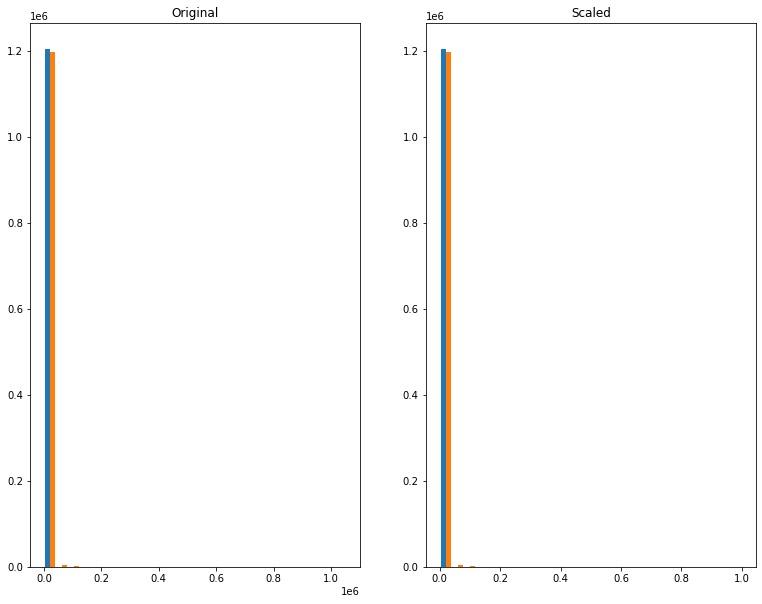

In [20]:
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)

plt.figure(figsize=(13, 10))
plt.subplot(121)
plt.hist(X_train, bins=25)
plt.title('Original')
plt.subplot(122)
plt.hist(X_train_scaled, bins=25)
plt.title('Scaled');

In [18]:
scaler.fit_transform(X_train)

array([[0.00361691, 0.00760059],
       [0.00263219, 0.00188441],
       [0.00976621, 0.03110946],
       ...,
       [0.00303511, 0.00420791],
       [0.00416292, 0.00364795],
       [0.0036828 , 0.00095958]])

### Standard Scaler:

Text(0.5, 1.0, 'Scaled')

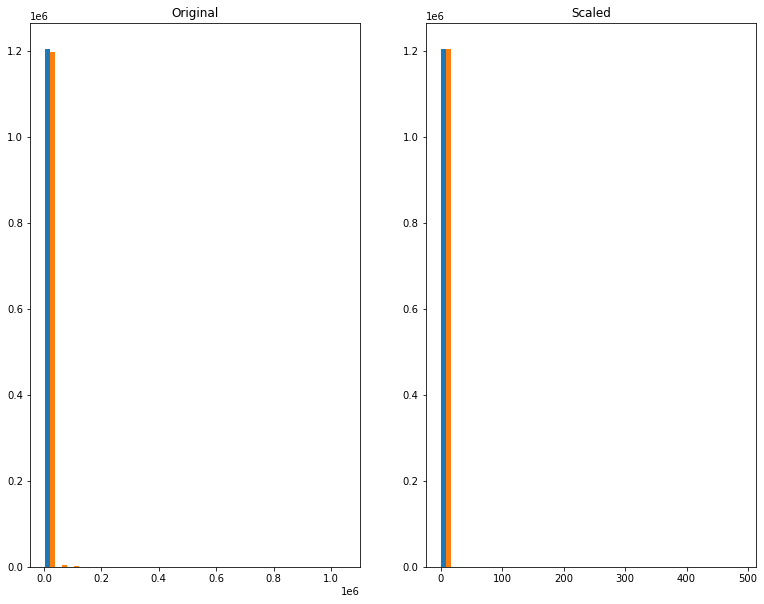

In [16]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

plt.figure(figsize=(13, 10))
plt.subplot(121)
plt.hist(X_train, bins=25)
plt.title('Original')
plt.subplot(122)
plt.hist(X_train_scaled, bins=25)
plt.title('Scaled')

Text(0.5, 1.0, 'Scaled')

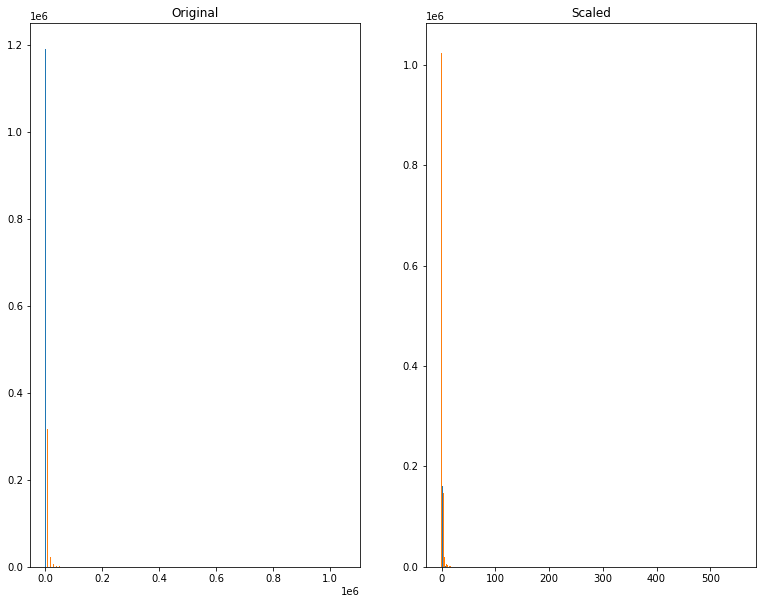

In [9]:
scaler = RobustScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

plt.figure(figsize=(13, 10))
plt.subplot(121)
plt.hist(X_train, bins=200)
plt.title('Original')
plt.subplot(122)
plt.hist(X_train_scaled, bins=200)
plt.title('Scaled')

## 2. Apply the .inverse_transform method to your scaled data. Is the resulting dataset the exact same as the original data?

## 3. Read the documentation for sklearn's QuantileTransformer. Use normal for the output_distribution and apply this scaler to your data. Visualize the result of your data scaling.